# Agent environment with bitflipping actions

## Neural network model details
 * Input: $\mathbb{R}^n$ vector representing the bit sequence (e.g. $00011 \sim (0, 0, 0, 1, 1)$)
 * Output: $\mathbb{R}^{n}$ vector of the $Q$-values
    * The index corresponds to integer $\geq 0$ representing the index of the bit being flipped
    * So $\text{model}(s)[a]$ will be the $Q$-value
 * Architecture: Simple MLP

## Training method
Simple DQN with replay
   * Exploration step -> update Q network -> validation step

**Exploration step**
We initialize 16 agents starting at random starting states (for each agent). The actions will be according to the DQN agent, and with probability $\epsilon$, a random action will be picked uniformly. We add this to the experience buffer.

**Update Q network**
Update the DQN to match Bellman's equation using a randomly sampled batch size ($=128$), and this is done with gradient descent.

**Validation step**
Access the performance of the learnt policy. Initialize 1024 random starting states, and let the agent fully decide the actions (we do not replace actions with probability $\epsilon$ with uniform distribution). Since this is the validation step, this should not interfere with the training process, and the experience buffer won't be updated.


## Notes
For an optimal agent, $E[\text{steps}] = \frac{1}{2^n}\sum_{k=0}^n \dbinom{n}{k}k = \frac{n}{2}$. We expect the average number of steps to be close to $\frac{n}{2}$ if an optimal agent is chosen.

In [1]:
from src.environments.env_bit_sequence_flipping import FlippingBitSequenceEnv
from src.agents.agent_dqn import DQNAgent
from src.models.model_dqn_bitflipping import BitFlippingDQNNetwork
from src.models.buffer_bitflipping import BufferBitflipping

import numpy as np
import torch

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda:0")

def train_DQN_agent(n: int, device: torch.device,
    episodes: int=1000, num_explore_agents: int=16, num_valid_agents: int=1024,
    batch_size: int=2048) -> None:

    # initialize environment, model and agent
    env = FlippingBitSequenceEnv(n, device)
    model = BitFlippingDQNNetwork(n)
    model.to(device)
    buffer = BufferBitflipping(n, device=device, no_repeat=True)
    agent = DQNAgent(model=model, buffer=buffer, device=device,
                    action_space_size=n)

    success_rates = []
    steps_to_success = []
    loss_values = []
    for e in tqdm(range(episodes)):
        # initial state is numpy array, convert to torch tensor
        state = env.reset(num_agents=num_explore_agents)

        # let agent act for at most 100 steps
        for _ in range(100):  # max time steps
            with torch.no_grad():
                action = agent.act(state)
                next_state, reward, done, info = env.step(action)
                prev_done = info["previous_done"] # tensor indicating if the prior state was already terminal
                prev_step_ongoing = ~prev_done
                agent.remember(state[prev_step_ongoing, :].cpu().numpy(), action[prev_step_ongoing].cpu().numpy(),
                               reward[prev_step_ongoing].cpu().numpy(), next_state[prev_step_ongoing, :].cpu().numpy(), done[prev_step_ongoing].cpu().numpy())
                state = next_state
                if done.all():
                    break
        
        # replay to update Q network
        loss = agent.replay(batch_size=batch_size)

        # now run the agent for at most 50 steps to see if it has learned (without random exploration, and without affecting the replay buffer)
        # we use random initial states
        state = env.reset(num_agents=num_valid_agents)
        agent_steps_to_success = np.ones(num_valid_agents)
        for step in range(100):  # max time steps
            with torch.no_grad():
                action = agent.act(state, explore=False)
                next_state, reward, done, info = env.step(action)
                prev_done = info["previous_done"] # tensor indicating if the prior state was already terminal
                prev_step_ongoing = ~prev_done
                state = next_state

                if step == 0: # if by random chance the agent is already done in the first step, we need to handle this case
                    agent_steps_to_success[prev_done.cpu().numpy()] = 0
                agent_steps_to_success[~done.cpu().numpy()] += 1
                if done.all():
                    break
        success_rate = ((done.sum().item() + 0.0) / num_valid_agents)
        avg_steps_to_success = agent_steps_to_success.mean()
        success_rates.append(success_rate)
        steps_to_success.append(avg_steps_to_success)
        loss_values.append(loss)

        if (e + 1) % 100 == 0:
            print("Episode: {}/{}, Epsilon: {}, Success rate: {:.2f}, Avg steps to success: {:.2f}, Loss: {:.6f}".format(e, episodes, agent.epsilon, success_rate, avg_steps_to_success, loss))
    
    # plot success rates and steps to success over episodes
    plt.figure(figsize=(24, 16))
    plt.subplot(3, 2, 1)
    plt.plot(success_rates)
    plt.xlabel("Episodes")
    plt.ylabel("Success rate")
    plt.title("Success rate over episodes")
    plt.subplot(3, 2, 2)
    plt.plot(steps_to_success)
    plt.xlabel("Episodes")
    plt.ylabel("Steps to success")
    plt.title("Steps to success over episodes")
    plt.subplot(3, 2, 3)
    plt.plot(np.clip(np.array(steps_to_success), n/2 - 1, n/2 + 1))
    plt.xlabel("Episodes")
    plt.ylabel("Steps to success")
    plt.title("Steps to success over episodes (Zoom)")
    plt.subplot(3, 2, 4)
    plt.plot(loss_values)
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.title("Loss over episodes")
    plt.subplot(3, 2, 5)
    plt.plot(np.clip(np.array(loss_values), 0.0, 0.01))
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.title("Loss over episodes (Zoom)")
    plt.show()

# Experiments

$n=2$, optimal agent achieved as steps $\sim 1$

Initialized FlippingBitSequenceEnv with n = 2. Randomly picked target: tensor([1, 1], device='cuda:0')
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


 10%|█         | 101/1000 [00:13<01:54,  7.82it/s]

Episode: 99/1000, Epsilon: 0.1351999253974994, Success rate: 1.00, Avg steps to success: 1.02, Loss: 0.000000


 20%|██        | 201/1000 [00:26<01:39,  8.00it/s]

Episode: 199/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 0.98, Loss: 0.000000


 30%|███       | 301/1000 [00:39<01:38,  7.10it/s]

Episode: 299/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 1.02, Loss: 0.000000


 40%|████      | 401/1000 [00:52<01:10,  8.45it/s]

Episode: 399/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 1.05, Loss: 0.000000


 50%|█████     | 501/1000 [01:03<00:56,  8.85it/s]

Episode: 499/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 1.03, Loss: 0.000000


 60%|██████    | 601/1000 [01:15<00:42,  9.31it/s]

Episode: 599/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 1.02, Loss: 0.000000


 70%|███████   | 701/1000 [01:26<00:34,  8.76it/s]

Episode: 699/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 1.00, Loss: 0.000000


 80%|████████  | 801/1000 [01:37<00:22,  8.87it/s]

Episode: 799/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 1.02, Loss: 0.000000


 90%|█████████ | 901/1000 [01:49<00:11,  8.81it/s]

Episode: 899/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 1.00, Loss: 0.000000


100%|██████████| 1000/1000 [02:00<00:00,  8.30it/s]


Episode: 999/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 0.97, Loss: 0.000000


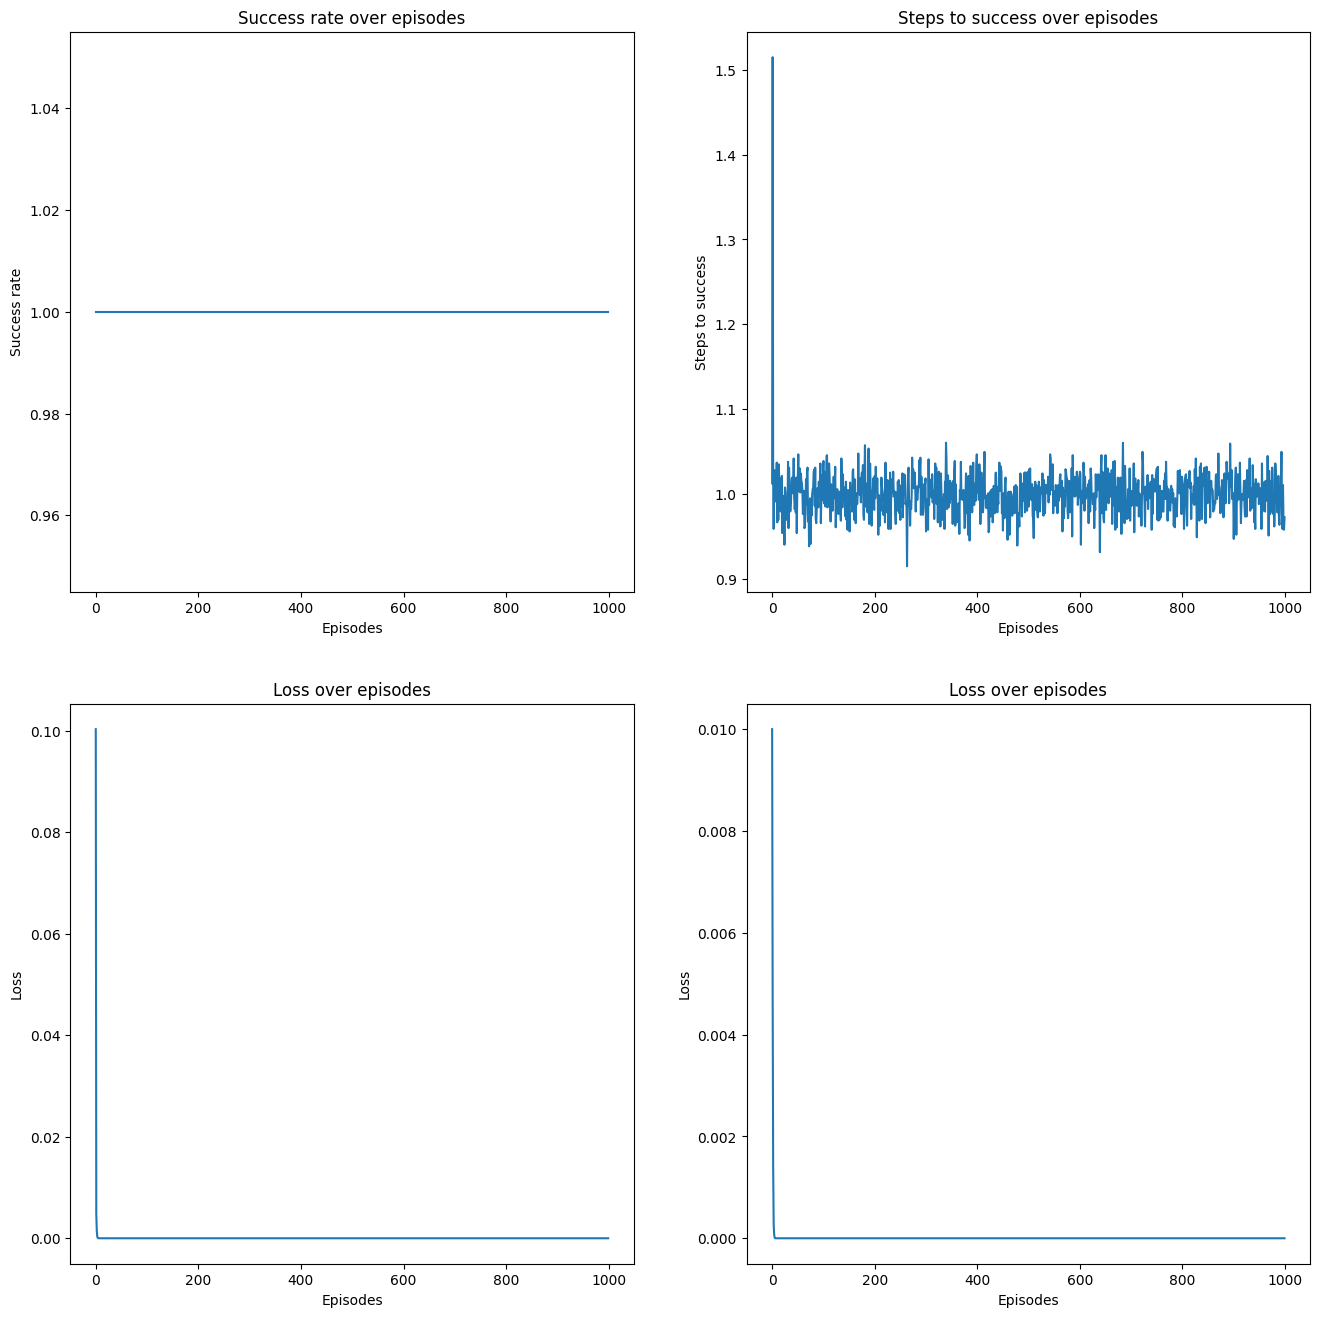

6


In [2]:
train_DQN_agent(2, device=device)

$n=3$, optimal agent achieved as steps $\sim \frac{3}{2}$

Initialized FlippingBitSequenceEnv with n = 3. Randomly picked target: tensor([1, 1, 1], device='cuda:0')
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Episode: 99/100, Epsilon: 0.1351999253974994, Success rate: 1.00, Avg steps to success: 1.47, Loss: 0.000001


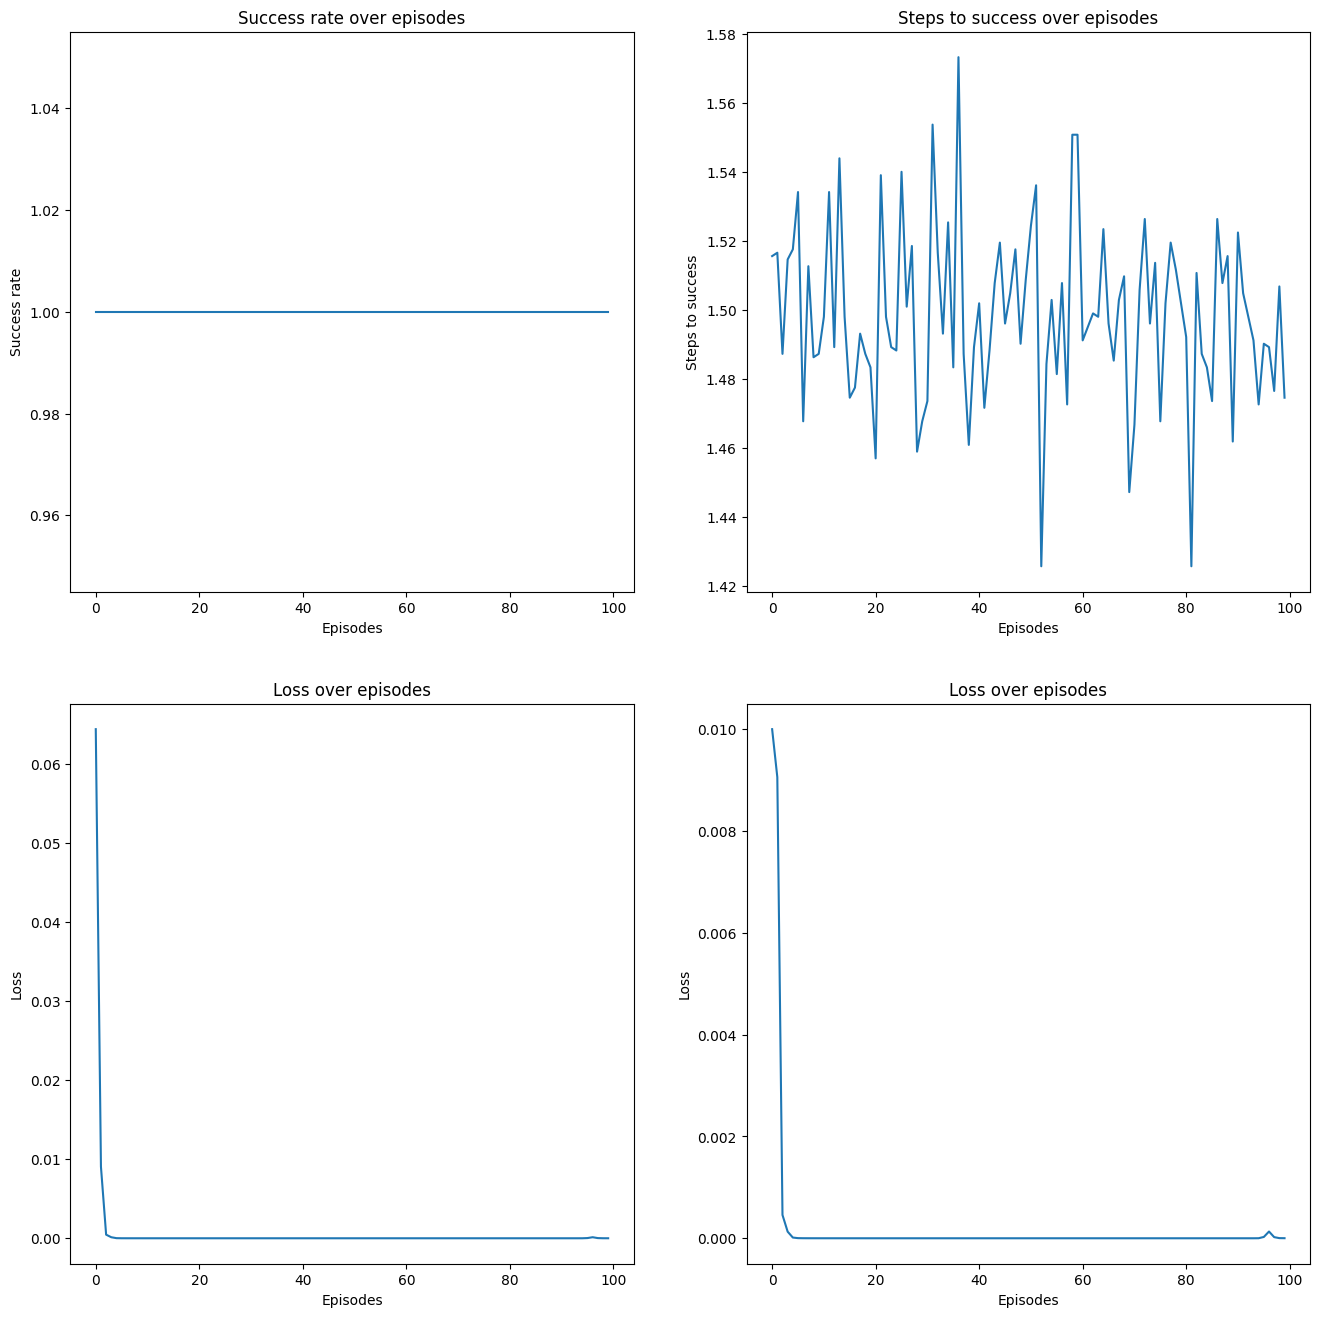

21


In [3]:
train_DQN_agent(3, device=device)

$n=6$, optimal agent achieved as steps $\sim 3$

Initialized FlippingBitSequenceEnv with n = 6. Randomly picked target: tensor([0, 1, 1, 0, 1, 0], device='cuda:0')
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


 10%|█         | 101/1000 [00:21<02:00,  7.49it/s]

Episode: 99/1000, Epsilon: 0.1351999253974994, Success rate: 1.00, Avg steps to success: 3.00, Loss: 0.000000


 20%|██        | 201/1000 [00:33<01:44,  7.66it/s]

Episode: 199/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 2.98, Loss: 0.000000


 30%|███       | 301/1000 [00:47<01:27,  7.95it/s]

Episode: 299/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 3.06, Loss: 0.000000


 40%|████      | 401/1000 [01:00<01:15,  7.95it/s]

Episode: 399/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 3.01, Loss: 0.000000


 50%|█████     | 501/1000 [01:13<01:07,  7.41it/s]

Episode: 499/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 3.02, Loss: 0.000000


 60%|██████    | 601/1000 [01:26<00:50,  7.85it/s]

Episode: 599/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 2.99, Loss: 0.000004


 70%|███████   | 701/1000 [01:39<00:37,  7.96it/s]

Episode: 699/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 2.99, Loss: 0.000000


 80%|████████  | 801/1000 [01:51<00:24,  8.19it/s]

Episode: 799/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 2.97, Loss: 0.000000


 90%|█████████ | 901/1000 [02:04<00:12,  7.78it/s]

Episode: 899/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 3.04, Loss: 0.000000


100%|██████████| 1000/1000 [02:17<00:00,  7.28it/s]


Episode: 999/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 2.96, Loss: 0.000000


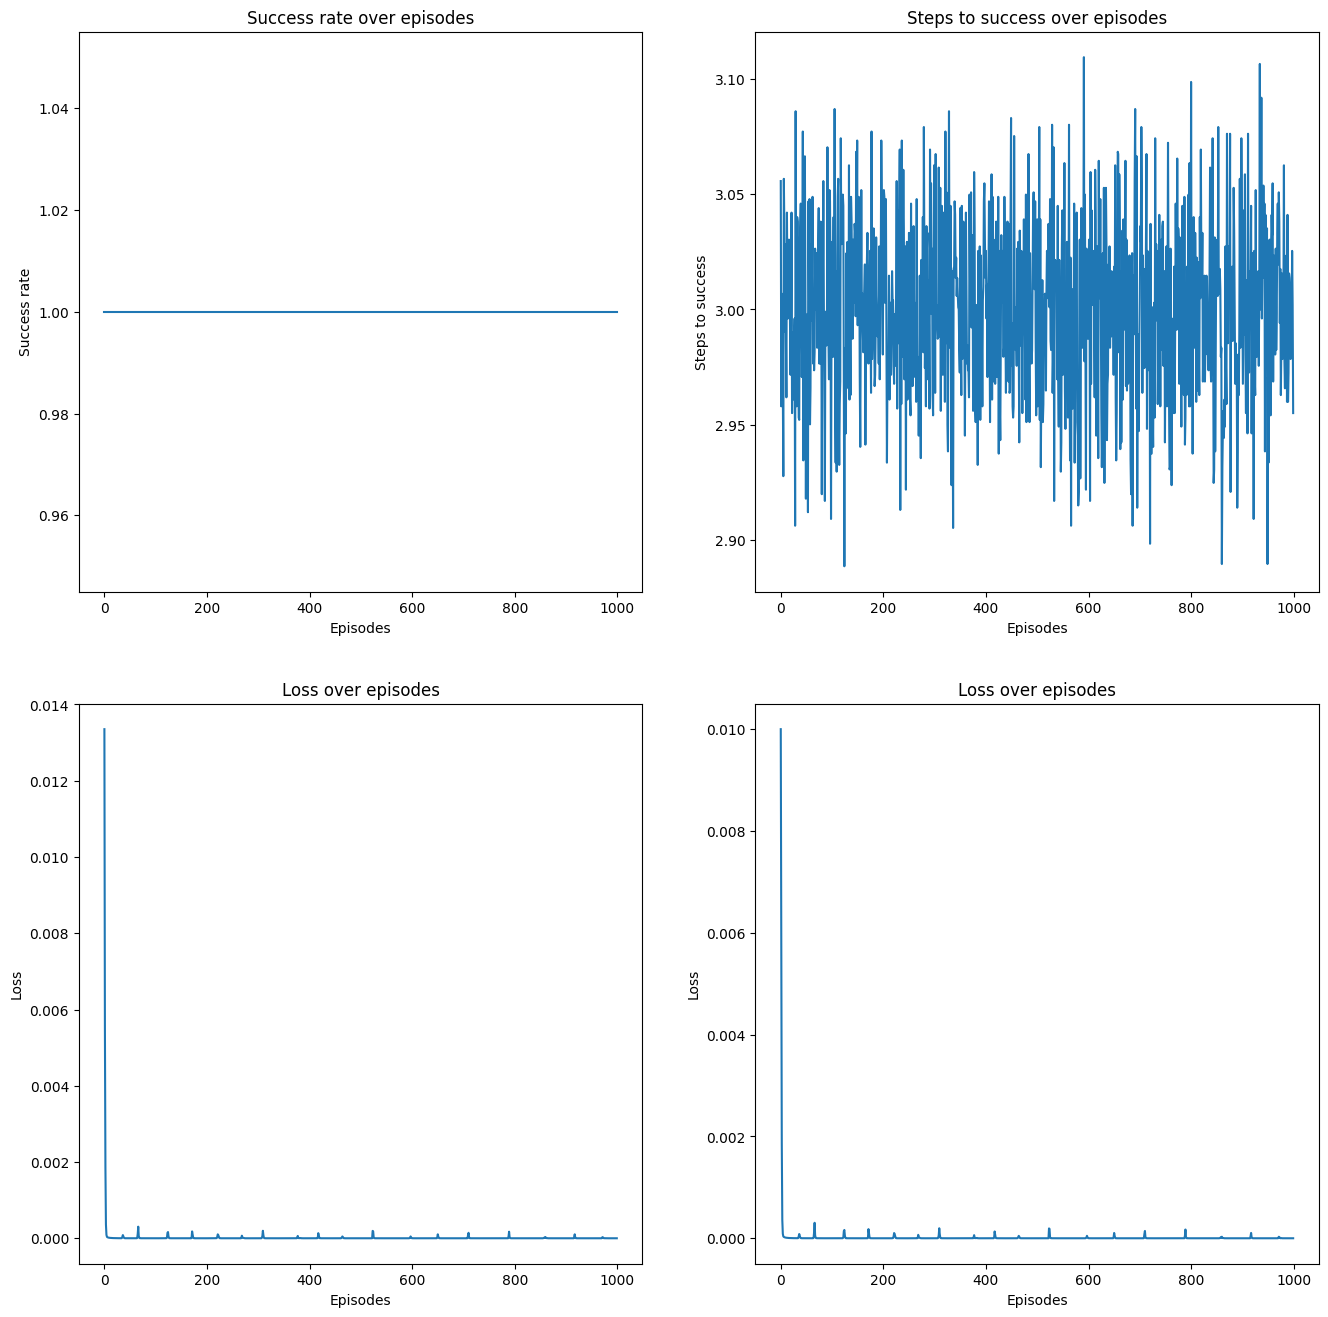

378


In [4]:
train_DQN_agent(6, device=device)

$n=10$, optimal agent achieved as steps $\sim 5$

In [5]:
train_DQN_agent(10, device=device)

Initialized FlippingBitSequenceEnv with n = 10. Randomly picked target: tensor([0, 0, 0, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.05
epsilon_decay: 0.999
learning_rate: 0.001


 10%|█         | 101/1000 [00:27<02:20,  6.40it/s]

Episode: 99/1000, Epsilon: 0.1351999253974994, Success rate: 1.00, Avg steps to success: 5.08, Loss: 0.000002


 20%|██        | 201/1000 [00:42<01:56,  6.88it/s]

Episode: 199/1000, Epsilon: 0.05, Success rate: 1.00, Avg steps to success: 5.02, Loss: 0.000001


 30%|███       | 300/1000 [01:02<05:18,  2.20it/s]

Episode: 299/1000, Epsilon: 0.05, Success rate: 0.12, Avg steps to success: 45.05, Loss: 0.000011


 38%|███▊      | 377/1000 [01:40<05:28,  1.90it/s]

$n=15$. Given more training epochs, an optimal agent could be found (avg steps 7.5)

In [ ]:
train_DQN_agent(15, device=device, episodes=4000)

Initialized FlippingBitSequenceEnv with n = 15. Randomly picked target: tensor([1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.01
epsilon_decay: 0.995
learning_rate: 0.05


  2%|▎         | 100/4000 [01:53<1:15:58,  1.17s/it]

Episode: 99/4000, Epsilon: 0.6057704364907278, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.004387


  5%|▌         | 200/4000 [03:43<1:02:26,  1.01it/s]

Episode: 199/4000, Epsilon: 0.3669578217261671, Success rate: 0.00, Avg steps to success: 50.95, Loss: 0.000183


  8%|▊         | 300/4000 [05:42<1:17:19,  1.25s/it]

Episode: 299/4000, Epsilon: 0.22229219984074702, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000067


 10%|█         | 400/4000 [07:46<1:13:21,  1.22s/it]

Episode: 399/4000, Epsilon: 0.1346580429260134, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000050


 12%|█▎        | 500/4000 [09:49<1:11:03,  1.22s/it]

Episode: 499/4000, Epsilon: 0.08157186144027828, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000044


 15%|█▌        | 600/4000 [11:51<1:09:09,  1.22s/it]

Episode: 599/4000, Epsilon: 0.0494138221100385, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000034


 18%|█▊        | 700/4000 [13:53<1:06:37,  1.21s/it]

Episode: 699/4000, Epsilon: 0.029933432588273214, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000024


 20%|██        | 800/4000 [15:54<1:04:55,  1.22s/it]

Episode: 799/4000, Epsilon: 0.018132788524664028, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000016


 22%|██▎       | 900/4000 [17:55<1:02:53,  1.22s/it]

Episode: 899/4000, Epsilon: 0.01098430721937979, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000012


 25%|██▌       | 1000/4000 [19:56<1:00:19,  1.21s/it]

Episode: 999/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000011


 28%|██▊       | 1100/4000 [21:57<58:00,  1.20s/it]  

Episode: 1099/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000008


 30%|███       | 1200/4000 [23:55<55:05,  1.18s/it]  

Episode: 1199/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 50.95, Loss: 0.000008


 32%|███▎      | 1300/4000 [25:52<49:49,  1.11s/it]  

Episode: 1299/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 50.95, Loss: 0.000023


 35%|███▌      | 1400/4000 [27:43<48:20,  1.12s/it]

Episode: 1399/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000007


 38%|███▊      | 1500/4000 [29:34<45:35,  1.09s/it]

Episode: 1499/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000007


 40%|████      | 1600/4000 [31:23<44:01,  1.10s/it]

Episode: 1599/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000006


 42%|████▎     | 1700/4000 [33:13<42:01,  1.10s/it]

Episode: 1699/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000010


 45%|████▌     | 1800/4000 [35:02<39:51,  1.09s/it]

Episode: 1799/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000005


 48%|████▊     | 1900/4000 [36:52<38:53,  1.11s/it]

Episode: 1899/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000009


 50%|█████     | 2000/4000 [38:42<36:38,  1.10s/it]

Episode: 1999/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000004


 52%|█████▎    | 2100/4000 [40:31<34:25,  1.09s/it]

Episode: 2099/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000005


 55%|█████▌    | 2200/4000 [42:21<33:02,  1.10s/it]

Episode: 2199/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000446


 57%|█████▊    | 2300/4000 [44:10<30:51,  1.09s/it]

Episode: 2299/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000009


 60%|██████    | 2400/4000 [46:03<32:00,  1.20s/it]

Episode: 2399/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000007


 62%|██████▎   | 2500/4000 [47:59<30:58,  1.24s/it]

Episode: 2499/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000004


 65%|██████▌   | 2600/4000 [49:56<27:24,  1.17s/it]

Episode: 2599/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000006


 68%|██████▊   | 2700/4000 [51:53<24:17,  1.12s/it]

Episode: 2699/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000004


 70%|███████   | 2800/4000 [53:48<23:06,  1.16s/it]

Episode: 2799/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.045515


 72%|███████▎  | 2900/4000 [55:45<22:53,  1.25s/it]

Episode: 2899/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000044


 75%|███████▌  | 3000/4000 [57:43<18:38,  1.12s/it]

Episode: 2999/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000037


 78%|███████▊  | 3100/4000 [59:40<17:07,  1.14s/it]

Episode: 3099/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000041


 80%|████████  | 3200/4000 [1:01:37<14:56,  1.12s/it]

Episode: 3199/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000055


 82%|████████▎ | 3300/4000 [1:03:34<13:44,  1.18s/it]

Episode: 3299/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000209


 85%|████████▌ | 3400/4000 [1:05:32<12:41,  1.27s/it]

Episode: 3399/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000062


 88%|████████▊ | 3500/4000 [1:07:27<09:35,  1.15s/it]

Episode: 3499/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 50.95, Loss: 0.000048


 90%|█████████ | 3600/4000 [1:09:24<07:21,  1.10s/it]

Episode: 3599/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000056


 92%|█████████▎| 3700/4000 [1:11:18<05:39,  1.13s/it]

Episode: 3699/4000, Epsilon: 0.01, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.000053


 95%|█████████▍| 3781/4000 [1:12:54<04:30,  1.24s/it]

There are 16 agents in each episode, taking 50 steps max. Assuming that a randomly initialized Q-network gives rise to agents that pick actions at random uniformly, we expect that the procedure to visit 800 states. Note that $4000 \times 800 >> 2^{15}$, so it is possible that the state to be reached. In this case, we pick $n=30$, so $\frac{2^{30}}{800}=1342177.28$, and it is probabilistically unlikely that the target state will be visited from random exploration or from the randomly initialized Q-network policy.

$n=30$, as expected, the optimal agent cannot be found. This is due to the reward being too sparse.

In [ ]:
train_DQN_agent(30, device=device, episodes=10000)

Initialized FlippingBitSequenceEnv with n = 30. Randomly picked target: tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 1, 1, 1], device='cuda:0')
-------------------- Initializing DQNAgent --------------------
gamma: 0.95
epsilon: 1.0
epsilon_min: 0.01
epsilon_decay: 0.995
learning_rate: 0.001


  1%|          | 100/10000 [01:41<3:47:32,  1.38s/it]

Episode: 99/10000, Epsilon: 0.6057704364907278, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.00


  2%|▏         | 200/10000 [04:20<5:45:57,  2.12s/it]

Episode: 199/10000, Epsilon: 0.3669578217261671, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.00


  3%|▎         | 300/10000 [07:51<5:41:17,  2.11s/it]

Episode: 299/10000, Epsilon: 0.22229219984074702, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.00


  4%|▍         | 400/10000 [11:34<5:27:25,  2.05s/it]

Episode: 399/10000, Epsilon: 0.1346580429260134, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.00


  5%|▌         | 500/10000 [16:25<10:10:15,  3.85s/it]

Episode: 499/10000, Epsilon: 0.08157186144027828, Success rate: 0.00, Avg steps to success: 51.00, Loss: 0.00


  5%|▌         | 501/10000 [16:29<10:15:12,  3.89s/it]